In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
#raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)

raw_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_evaluated.csv')
GNN_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_GNNRank_evaluated.csv')
raw_df = pd.concat([raw_df, GNN_df])

#raw_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_stratified_evaluated.csv')

#raw_df = pd.read_csv('./data/post_processing/EPIRA_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/EPIRA99_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/FAstarIR_10trials.csv')

raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})

raw_df

,trial,iteration,value,sampling method,Ranking Method,metric,group,bias_applied
0,0,100,0.205576,randomSampling,rankCentrality,tau,Overall,True
1,0,100,0.201137,randomSampling,rankCentrality,tau,Privileged,True
2,0,100,0.205958,randomSampling,rankCentrality,tau,Unprivileged,True
3,0,100,0.094700,randomSampling,rankCentrality,exposure,Privileged,True
4,0,100,0.089017,randomSampling,rankCentrality,exposure,Unprivileged,True
...,...,...,...,...,...,...,...,...
21371,9,1000,0.094995,rankSampling,GNNRank,exposure,Privileged,True
21372,9,1000,0.088641,rankSampling,GNNRank,exposure,Unprivileged,True
21373,9,1000,0.239367,rankSampling,GNNRank,tau,Privileged within-group,True
21374,9,1000,0.231184,rankSampling,GNNRank,tau,Between groups,True


In [81]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

,iteration,bias_applied,sampling method,metric,group,Ranking Method,trial,value,exposure,tau
0,500,True,oversampling,exposure,Privileged,GNNRank,4.5,0.094308,0.094308,NaN
1,500,True,oversampling,exposure,Privileged,davidScore,4.5,0.091926,0.091926,NaN
2,500,True,oversampling,exposure,Privileged,fairPageRank,4.5,0.090140,0.090140,NaN
3,500,True,oversampling,exposure,Privileged,randomRankRecovery,4.5,0.092308,0.092308,NaN
4,500,True,oversampling,exposure,Privileged,rankCentrality,4.5,0.092039,0.092039,NaN
...,...,...,...,...,...,...,...,...,...,...
115,500,True,rankSampling,tau,Unprivileged within-group,GNNRank,4.5,0.272037,NaN,0.272037
116,500,True,rankSampling,tau,Unprivileged within-group,davidScore,4.5,0.225960,NaN,0.225960
117,500,True,rankSampling,tau,Unprivileged within-group,fairPageRank,4.5,0.305092,NaN,0.305092
118,500,True,rankSampling,tau,Unprivileged within-group,randomRankRecovery,4.5,0.707635,NaN,0.707635


In [82]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

,bias_applied,sampling method,metric,group,Ranking Method,exposure,tau
0,True,oversampling,exposure,Privileged,GNNRank,0.094308,NaN
1,True,oversampling,exposure,Privileged,davidScore,0.091926,NaN
2,True,oversampling,exposure,Privileged,fairPageRank,0.090140,NaN
3,True,oversampling,exposure,Privileged,randomRankRecovery,0.092308,NaN
4,True,oversampling,exposure,Privileged,rankCentrality,0.092039,NaN
20,True,oversampling,tau,Privileged,GNNRank,NaN,0.327325
21,True,oversampling,tau,Privileged,davidScore,NaN,0.172090
22,True,oversampling,tau,Privileged,fairPageRank,NaN,0.294507
23,True,oversampling,tau,Privileged,randomRankRecovery,NaN,0.705392
24,True,oversampling,tau,Privileged,rankCentrality,NaN,0.179625


In [83]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

,bias_applied,sampling method,metric,Ranking Method,exposure_priv,tau_priv,exposure_unpriv,tau_unpriv,exposure ratio,error ratio
0,True,oversampling,exposure,GNNRank,0.094308,NaN,0.089517,NaN,0.949196,NaN
1,True,oversampling,exposure,davidScore,0.091926,NaN,0.092550,NaN,1.006786,NaN
2,True,oversampling,exposure,fairPageRank,0.090140,NaN,0.094826,NaN,1.051988,NaN
3,True,oversampling,exposure,randomRankRecovery,0.092308,NaN,0.092064,NaN,0.997357,NaN
4,True,oversampling,exposure,rankCentrality,0.092039,NaN,0.092407,NaN,1.004002,NaN
5,True,oversampling,tau,GNNRank,NaN,0.327325,NaN,0.324771,NaN,1.007865
6,True,oversampling,tau,davidScore,NaN,0.172090,NaN,0.172228,NaN,0.999202
7,True,oversampling,tau,fairPageRank,NaN,0.294507,NaN,0.314177,NaN,0.937393
8,True,oversampling,tau,randomRankRecovery,NaN,0.705392,NaN,0.705584,NaN,0.999728
9,True,oversampling,tau,rankCentrality,NaN,0.179625,NaN,0.180449,NaN,0.995437


In [84]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

,bias_applied,sampling method,Ranking Method,exposure ratio,error ratio,error
0,True,oversampling,GNNRank,0.949196,1.007865,0.328775
1,True,oversampling,davidScore,1.006786,0.999202,0.172492
2,True,oversampling,fairPageRank,1.051988,0.937393,0.291074
3,True,oversampling,randomRankRecovery,0.997357,0.999728,0.705597
4,True,oversampling,rankCentrality,1.004002,0.995437,0.180042
5,True,randomSampling,GNNRank,0.937443,1.010834,0.245941
6,True,randomSampling,davidScore,0.934981,0.962624,0.151904
7,True,randomSampling,fairPageRank,1.054464,0.930761,0.268770
8,True,randomSampling,randomRankRecovery,1.001031,0.998053,0.707099
9,True,randomSampling,rankCentrality,0.934101,0.959290,0.160254


In [85]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

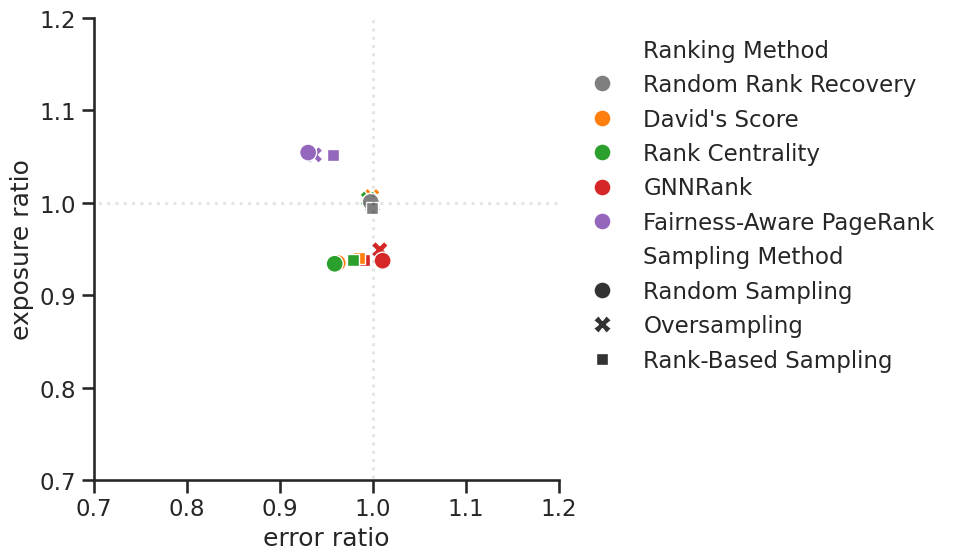

In [86]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling']
df = df[df['Ranking Method'].isin(ranking_methods)]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank'],
                         style_order=['Random Sampling', 'Oversampling', 'Rank-Based Sampling'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()

## Seperate 1D Plots

In [87]:
sel_df2 = raw_df[(raw_df.iteration == 500) & raw_df.bias_applied].drop(columns=['iteration', 'bias_applied'])
sel_df2 = sel_df2.pivot(index=['trial', 'sampling method', 'Ranking Method'], columns=['metric', 'group'], values='value').reset_index()
sel_df2

metric trial sampling method      Ranking Method       tau             \
group                                              Overall Privileged   
0          0    oversampling             GNNRank  0.265906   0.265274   
1          0    oversampling          davidScore  0.172854   0.172443   
2          0    oversampling        fairPageRank  0.290254   0.293896   
3          0    oversampling  randomRankRecovery  0.709447   0.711206   
4          0    oversampling      rankCentrality  0.179918   0.179476   
..       ...             ...                 ...       ...        ...   
145        9    rankSampling             GNNRank  0.239235   0.234421   
146        9    rankSampling          davidScore  0.209520   0.206743   
147        9    rankSampling        fairPageRank  0.362916   0.369158   
148        9    rankSampling  randomRankRecovery  0.711239   0.709006   
149        9    rankSampling      rankCentrality  0.207944   0.203886   

metric                exposure                                  tau  \
group  Unprivileged Privileged Unprivileged Privileged within-group   
0          0.259567   0.094526     0.089239                0.278584   
1          0.173024   0.091960     0.092507                0.172502   
2          0.312586   0.090153     0.094809                0.237380   
3          0.706589   0.092199     0.092202                0.715332   
4          0.180824   0.092062     0.092378                0.178026   
..              ...        ...          ...                     ...   
145        0.239172   0.094995     0.088641                0.239367   
146        0.206635   0.094657     0.089072                0.215376   
147        0.385850   0.090021     0.094977                0.310038   
148        0.714972   0.092184     0.092221                0.703442   
149        0.207458   0.095028     0.088599                0.208948   

metric                                           
group  Between groups Unprivileged within-group  
0            0.256350                  0.269009  
1            0.172406                  0.174868  
2            0.325089                  0.271543  
3            0.708541                  0.700686  
4            0.180402                  0.182087  
..                ...                       ...  
145          0.231184                  0.261725  
146          0.200996                  0.222734  
147          0.402615                  0.330349  
148          0.712562                  0.722170  
149          0.200563                  0.226931  

[150 rows x 11 columns]

In [88]:
sel_df3 = sel_df2.copy()
sel_df3['exposure ratio'] = sel_df3['exposure']['Unprivileged'] / sel_df3['exposure']['Privileged']
sel_df3['error ratio'] = sel_df3['tau']['Unprivileged'] / sel_df3['tau']['Privileged']
sel_df3['error'] = sel_df3['tau']['Overall']
sel_df3 = sel_df3[['trial', 'sampling method', 'Ranking Method', 'exposure ratio', 'error ratio', 'error']].droplevel('group', axis=1)
sel_df3 = sel_df3.replace({'OversampleMinority': 'Oversampling',
                            'oversampling': 'Oversampling',
                            'RankSampling': 'Rank-Based Sampling',
                            'rankSampling': 'Rank-Based Sampling',
                            'RandomSampling': 'Random Sampling',
                            'randomSampling': 'Random Sampling',
                            'fairPageRank': 'Fairness-Aware PageRank',
                            'davidScore': "David's Score",
                            'randomRankRecovery': 'Random Rank Recovery',
                            'rankCentrality': 'Rank Centrality'})

sel_df3 = sel_df3.rename(columns={'sampling method': 'Sampling Method'})
sel_df3

metric,trial,Sampling Method,Ranking Method,exposure ratio,error ratio,error
0,0,Oversampling,GNNRank,0.944069,0.978487,0.265906
1,0,Oversampling,David's Score,1.005956,1.003365,0.172854
2,0,Oversampling,Fairness-Aware PageRank,1.051652,1.063593,0.290254
3,0,Oversampling,Random Rank Recovery,1.000029,0.993508,0.709447
4,0,Oversampling,Rank Centrality,1.003434,1.007512,0.179918
...,...,...,...,...,...,...
145,9,Rank-Based Sampling,GNNRank,0.933110,1.020267,0.239235
146,9,Rank-Based Sampling,David's Score,0.940997,0.999479,0.209520
147,9,Rank-Based Sampling,Fairness-Aware PageRank,1.055051,1.045214,0.362916
148,9,Rank-Based Sampling,Random Rank Recovery,1.000403,1.008414,0.711239


In [89]:
# Okabe-Ito color palette
lightblue = "#56B4E9"
yellow = "#F0E442"
orange = "#E69F00"
green = "#009E73"
purple = "#CC79A7"
red = "#D55E00"
blue = "#0072B2"
black = "#000000"
palette = [black, orange, lightblue, green, yellow, blue, red, purple]

palette = sns.color_palette('tab10')
#palette[0] = palette[7]

sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = sel_df3
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling']
metrics = ['exposure ratio', 'error ratio', 'error']

df = df[df['Ranking Method'].isin(ranking_methods)]
df = df.melt(id_vars=['Sampling Method', 'Ranking Method'], value_vars=['exposure ratio', 'error ratio', 'error'])

df['metric_order'] = df.metric.map(metrics.index)
df['sampling_order'] = df['Sampling Method'].map(sampling_methods.index)
df['ranking_order'] = df['Ranking Method'].map(list(reversed(ranking_methods)).index)
df = df.sort_values(by=['ranking_order', 'sampling_order', 'metric_order']).drop(columns=['ranking_order', 'sampling_order', 'metric_order'])

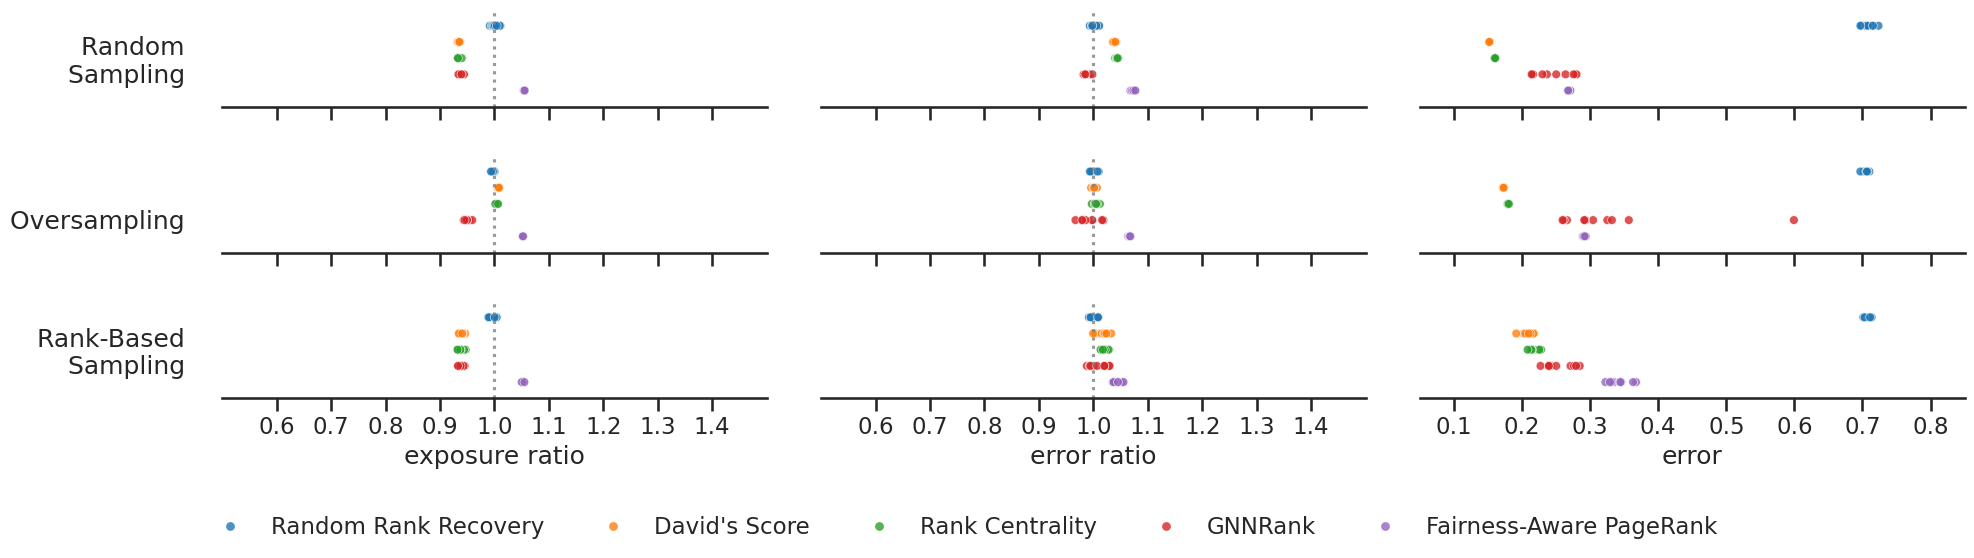

In [90]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.relplot(df, x='value', y='Ranking Method', hue='Ranking Method', kind='scatter', #style='Sampling Method',
                    row='Sampling Method', col='metric',
                    hue_order=ranking_methods, style_order=sampling_methods,
                    s=40, alpha=0.8, aspect=4/1, height=1.8, facet_kws={'sharey': True, 'sharex': False})

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=1, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(0.5,1.5))
        ax.set_xticks([.6,.7,.8,.9,1,1.1,1.2,1.3,1.4])
    
    if col_val == 'exposure ratio':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
#plt.savefig('./data/others_results/combined_results_1D.png', dpi=300, bbox_inches="tight")

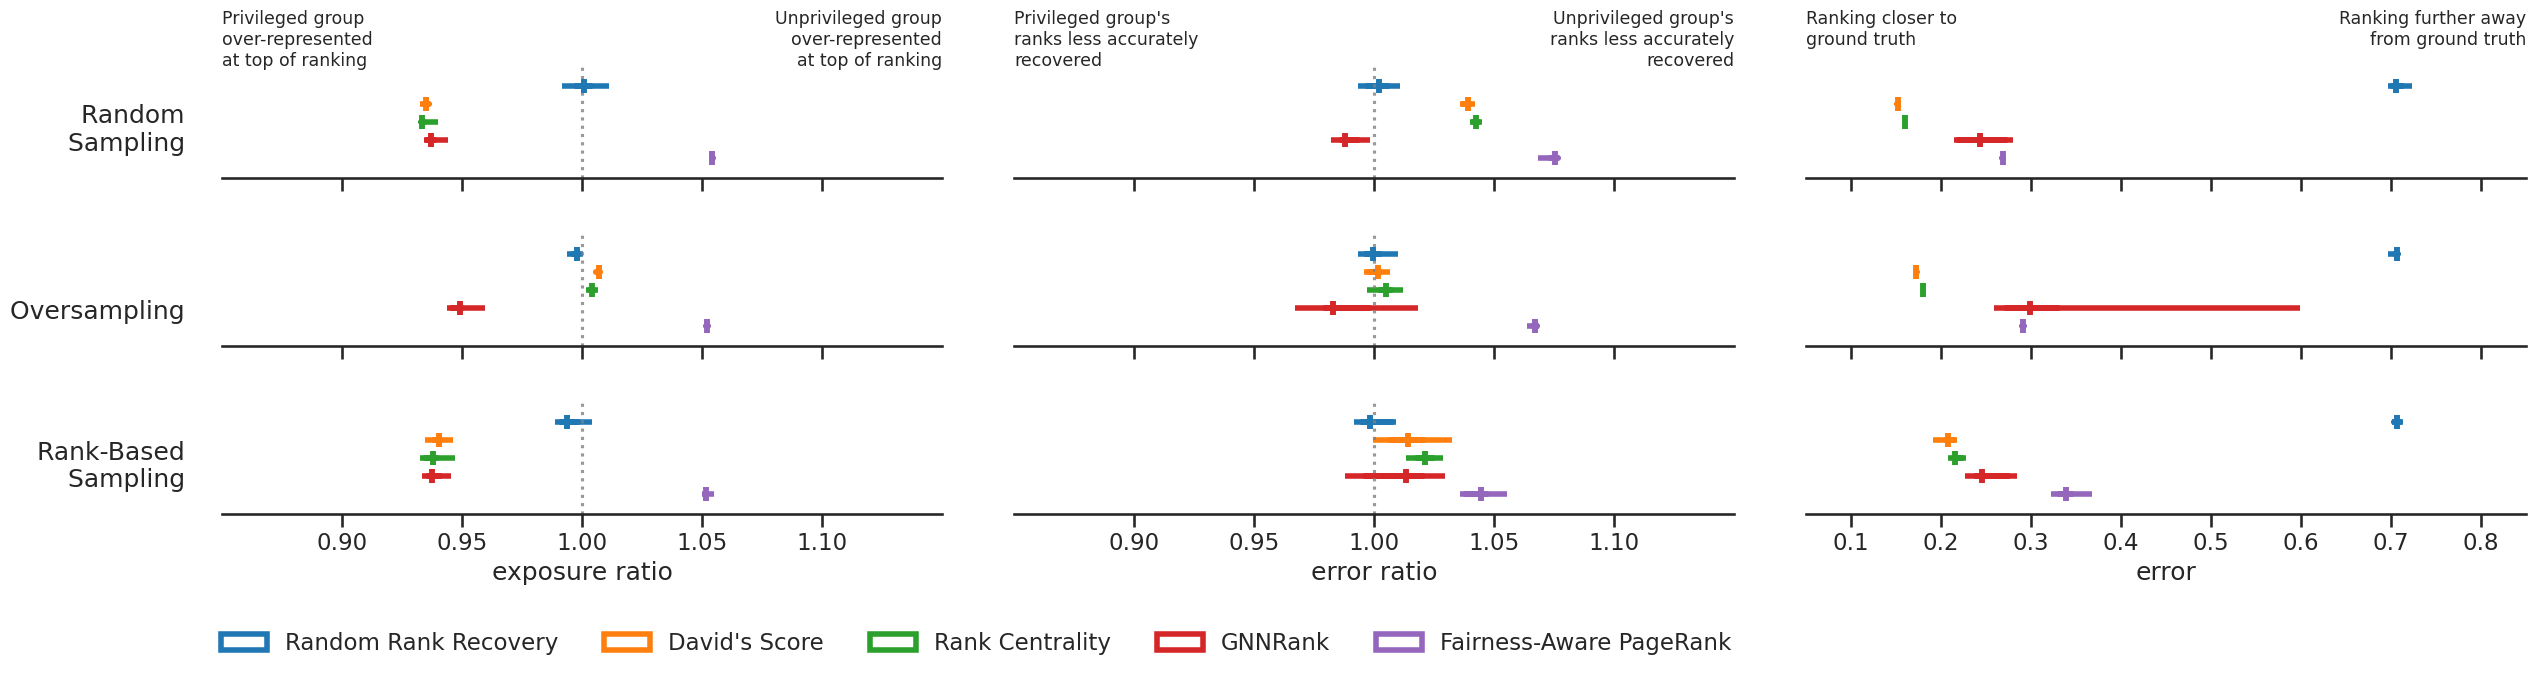

In [91]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.catplot(df, x='value', kind='box', #style='Sampling Method',
                    row='Sampling Method', col='metric', hue='Ranking Method',
                    hue_order=ranking_methods, sharex=False, sharey=True,
                    aspect=4/1, height=2,
                    # sns.boxplot properties
                    fill=False, whis=100, linewidth=4,
                    # plt.boxplot properties & Line2D properties
                    medianprops={'marker': '|', 'markeredgewidth': 4, 'markersize': 10}, showcaps=False,
                    #showmeans=True, meanprops={'marker': '|', 'markeredgecolor': 'black', 'markeredgewidth': 2, 'markersize': 10},
                    widths=0)
    # s=40, alpha=0.8, facet_kws={'sharey': True, 'sharex': False}, height=1.8

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.007, 0))

g.refline(x=1, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((0.5,-0.5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(0.85,1.15))
        ax.set_xticks([.9,.95,1,1.05,1.1])
    
    if col_val == 'exposure ratio':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)
    
    if row_val == 'Random Sampling':
        y = -.5
        y_offset = -.5
        if col_val == 'exposure ratio':
            ax.annotate('Privileged group\nover-represented\nat top of ranking',
                        xy=(0.85, y), xytext=(0.85,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\nover-represented\nat top of ranking',
                        xy=(1.15, y), xytext=(1.15,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error ratio':
            ax.annotate('Privileged group\'s\nranks less accurately\nrecovered',
                        xy=(0.85, y), xytext=(0.85,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\'s\nranks less accurately\nrecovered',
                        xy=(1.15, y), xytext=(1.15,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error':
            ax.annotate('Ranking closer to\nground truth',
                        xy=(0.05, y), xytext=(0.05,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Ranking further away\nfrom ground truth',
                        xy=(.85, y), xytext=(0.85,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')

sns.despine(left=True)
plt.savefig('./data/others_results/IMDB-WIKI_results_1D_V2.png', dpi=300, bbox_inches="tight")